In [1]:
import pandas as pd
import numpy as np
from functions import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

##### GME Analysis

In [2]:
stock= 'gme'

In [3]:
def data_loading_processing(stock):
    stock_df = pd.read_csv(f'./Data/{stock}.csv')
    labels = pd.read_csv(f'./Data/{stock}_labels.csv',header=None)[0]
    weekly_rv = pd.read_csv(f'./Data/{stock}_weekly_return_volatility.csv')
    stock_wr = trade_from_close_close(stock_df)
    stock_wr.loc[:,'Label'] = "NoLabel"
    # apply labels collected by visual inspection for last two years
    stock_wr.loc[stock_wr.shape[0] - labels.shape[0]:,'Label'] = labels.values
    weekly_rv = pd.concat([weekly_rv, pd.Series(np.insert(labels,0,
                    ['NoLabel']*(weekly_rv.shape[0] - labels.shape[0])),name='Label')], axis=1)
    all_data = pd.concat([stock_wr,weekly_rv],axis=1)
    return (weekly_rv,stock_wr,all_data.loc[:,~all_data.columns.duplicated()])

In [4]:
stock_data = data_loading_processing(stock)[2]
head_tail(stock_data)

,Year,Year_Week,Begin_Price,Adj Close,Return,Label,Week_Number,mean_return,volatility
0,2017,2017-01,6.36,4.99,0.784591,NoLabel,1,-0.82525,2.466974
1,2017,2017-02,4.99,4.62,0.925852,NoLabel,2,-1.44700,3.705994
261,2021,2021-51,38.91,38.03,0.977384,Red,51,-0.55650,1.666374
262,2021,2021-52,38.03,38.83,1.021036,Red,52,0.56150,3.340023


In [5]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=0)
train_X = stock_data[stock_data['Year'].isin([2020])][['Return','volatility']]
train_y = stock_data[stock_data['Year'].isin([2020])]['Label']
test_X = stock_data[stock_data['Year'].isin([2021])][['Return','volatility']]
test_y = stock_data[stock_data['Year'].isin([2021])]['Label']
dt.fit(stock_data[stock_data['Year'].isin([2020])][['Return','volatility']],
       stock_data[stock_data['Year'].isin([2020])]['Label'])
predictions = dt.predict(test_X)
dt.score(test_X,test_y)

0.8846153846153846

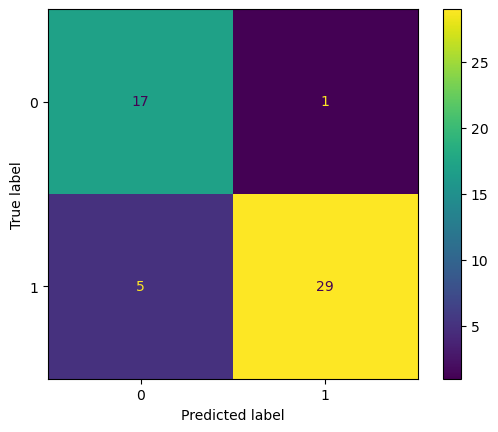

In [6]:
cm = confusion_matrix(test_y,predictions)
disp = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [7]:
cm

array([[17,  1],
       [ 5, 29]])

In [8]:
tpr(cm), tnr(cm)

(0.85, 0.94)

In [9]:
print(f'For decision tree predictions for {stock} in year 2 \
true positive rate, or sesnsitivity/recall, is the proportion of "Green" labels\
 correctly identified and is {tpr(cm)}\
 while true negative rate, or specificity is the proportion of "Red" labels \
 correctly identified and is {tnr(cm)}\
')

For decision tree predictions for gme in year 2 true positive rate, or sesnsitivity/recall, is the proportion of "Green" labels correctly identified and is 0.85 while true negative rate, or specificity is the proportion of "Red" labels  correctly identified and is 0.94


In [10]:
predictions

array(['Red', 'Green', 'Green', 'Green', 'Red', 'Red', 'Red', 'Green',
       'Green', 'Green', 'Red', 'Red', 'Green', 'Red', 'Red', 'Red',
       'Green', 'Red', 'Green', 'Green', 'Green', 'Green', 'Red', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Green', 'Red', 'Red', 'Green', 'Red',
       'Green', 'Green', 'Red', 'Green', 'Red', 'Red', 'Red', 'Green',
       'Red', 'Red', 'Green', 'Red', 'Green', 'Green', 'Red', 'Red',
       'Green', 'Red', 'Red'], dtype=object)

In [11]:
trade_labels(stock_data,2021,np.where(predictions == 'Green',1,0))

41867.41

In [12]:
buy_and_hold(stock_data,2021)

807.43

In [13]:
print(f'For {stock}, b&h yields {buy_and_hold(stock_data,2021)} \
while trading based on decision tree labels yields \
{trade_labels(stock_data,2021,np.where(predictions == "Green",1,0))}')

For gme, b&h yields 807.43 while trading based on decision tree labels yields 41867.41


###### Random Forest

Idea: generate list of dictionaries that contain all possible combinations of parameters that can then be iterated over to get accuracies.

In [14]:
test_results = []
for d in range(1,6):
    for n in range(1,11):
        rf = RandomForestClassifier(criterion = 'entropy', 
                                    n_estimators=n,
                                    max_depth=d,random_state=1)
        rf.fit(train_X,train_y)
        test_results.append((d,n,accuracy_score(test_y,rf.predict(test_X))))
        # rf.score(train_X,train_y)
        

In [15]:
results_df = pd.DataFrame(test_results, columns = ['d','n','accuracy'])
results_df['error'] = 1- results_df['accuracy']

In [16]:
results_df

,d,n,accuracy,error
0,1,1,0.596154,0.403846
1,1,2,0.923077,0.076923
2,1,3,0.596154,0.403846
3,1,4,0.826923,0.173077
4,1,5,0.826923,0.173077
5,1,6,0.826923,0.173077
6,1,7,0.923077,0.076923
7,1,8,0.923077,0.076923
8,1,9,0.923077,0.076923
9,1,10,0.923077,0.076923


[Text(0.5, 1.0, 'GME RF Error')]

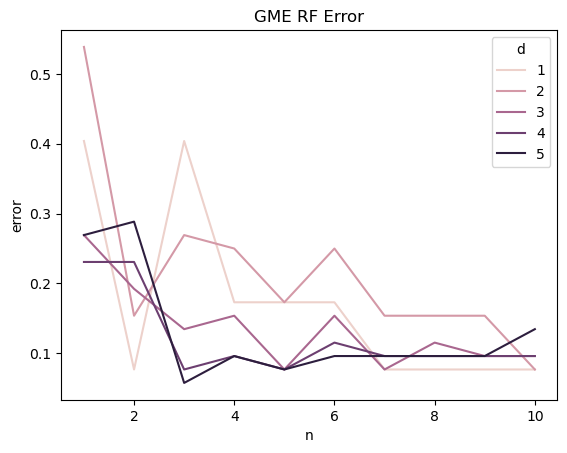

In [17]:
sns.lineplot(results_df, x = 'n', y = 'error', hue='d').set(title = f'{stock.upper()} RF Error')

In [18]:
results_df[results_df.accuracy == 
results_df.loc[results_df['accuracy'].idxmax(),'accuracy']]

,d,n,accuracy,error
42,5,3,0.942308,0.057692


With depth of 5 and n_trees of 3 there is 94.23% accuracy.

In [19]:
rf = RandomForestClassifier(n_estimators=3, max_depth=5,criterion = 'entropy',random_state=0)

In [20]:
rf.fit(train_X,train_y)
preds = rf.predict(test_X)
cm = confusion_matrix(test_y,preds)
print(f'tpr: {tpr(cm)}, tnr: {tnr(cm)}')

tpr: 0.74, tnr: 0.72


In [21]:
cm

array([[13,  5],
       [ 9, 25]])

In [22]:
trade_labels(stock_data,2021,np.where(preds == "Green",1,0))

5107.95

In [23]:
buy_and_hold(stock_data,2021)

807.43

###### Adaboost

In [24]:
test_results = []
gnb = GaussianNB()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
estimators = [gnb,lr,dt]
for l in [.5,1]:
    for e in estimators:
        for n in range(1,16):
            ab = AdaBoostClassifier(estimator = e,learning_rate=l,
                                    n_estimators=n)
            
            ab.fit(train_X,train_y)
            test_results.append((l,
                str(type(e)).split('.')[-1][:-2],
                n,accuracy_score(test_y,ab.predict(test_X))))
test_results = pd.DataFrame(test_results,columns=['Lambda',"Estimator",'N_Estimators','Accuracy'])

In [25]:
test_results['Error'] = 1- test_results['Accuracy']

In [26]:
test_results[test_results.Estimator=='LogisticRegression']

,Lambda,Estimator,N_Estimators,Accuracy,Error
15,0.5,LogisticRegression,1,0.596154,0.403846
16,0.5,LogisticRegression,2,0.596154,0.403846
17,0.5,LogisticRegression,3,0.596154,0.403846
18,0.5,LogisticRegression,4,0.596154,0.403846
19,0.5,LogisticRegression,5,0.596154,0.403846
20,0.5,LogisticRegression,6,0.596154,0.403846
21,0.5,LogisticRegression,7,0.596154,0.403846
22,0.5,LogisticRegression,8,0.596154,0.403846
23,0.5,LogisticRegression,9,0.596154,0.403846
24,0.5,LogisticRegression,10,0.596154,0.403846


In [27]:
lambda_pt_5 = test_results[test_results.Lambda==.5].loc[
test_results[test_results.Lambda==.5].groupby('Estimator')[
'Accuracy'].agg('idxmax').values,:
]
lambda_pt_5

,Lambda,Estimator,N_Estimators,Accuracy,Error
32,0.5,DecisionTreeClassifier,3,0.903846,0.096154
1,0.5,GaussianNB,2,0.846154,0.153846
15,0.5,LogisticRegression,1,0.596154,0.403846


In [28]:
test_results[test_results.Lambda==1].loc[
test_results[test_results.Lambda==1].groupby('Estimator')[
'Accuracy'].agg('idxmax').values,:
]

,Lambda,Estimator,N_Estimators,Accuracy,Error
75,1.0,DecisionTreeClassifier,1,0.903846,0.096154
50,1.0,GaussianNB,6,0.903846,0.096154
60,1.0,LogisticRegression,1,0.596154,0.403846


In [29]:
lambda_pt_5

,Lambda,Estimator,N_Estimators,Accuracy,Error
32,0.5,DecisionTreeClassifier,3,0.903846,0.096154
1,0.5,GaussianNB,2,0.846154,0.153846
15,0.5,LogisticRegression,1,0.596154,0.403846


In the table above we wee that best estimator is The DecisionTreeClassifier.

/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


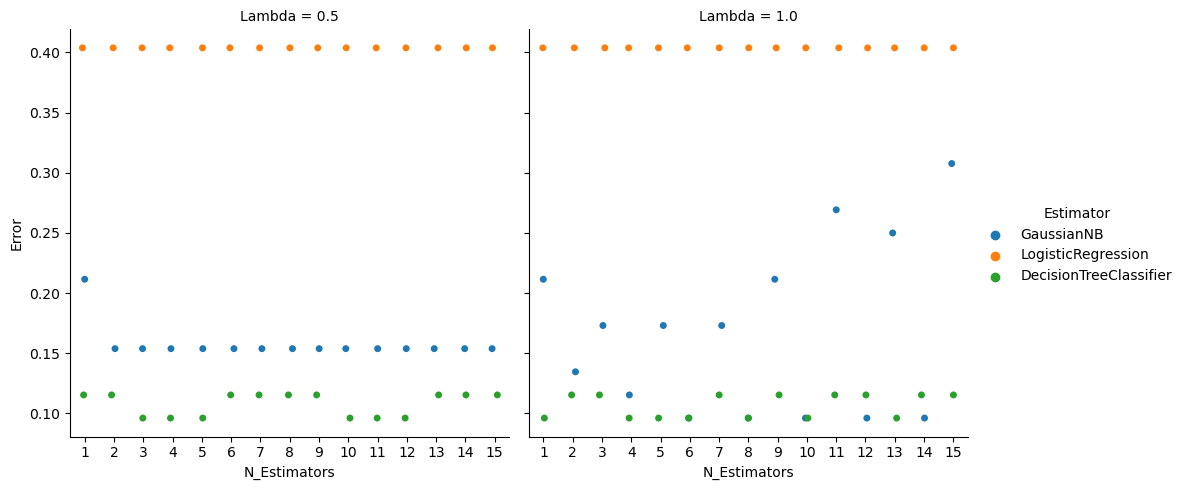

In [30]:
sns.catplot(data=test_results, col = "Lambda",x='N_Estimators',y='Error',
hue = 'Estimator')

for lambda = .5, the best estimator is decision tree with n_estimators = 2

In [31]:
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(),n_estimators = 2,
                          learning_rate=.5)
ab.fit(train_X,train_y)
preds = ab.predict(test_X)
preds = np.where(preds=="Green",1,0)

In [32]:
trade_labels(stock_data,2021,preds)

45250.34

In [33]:
buy_and_hold(stock_data,2021)

807.43

##### S&P 500

In [34]:
stock = 'SPY'

In [35]:
stock_data = data_loading_processing('spy')[2]
head_tail(stock_data)

,Year,Year_Week,Begin_Price,Adj Close,Return,Label,Week_Number,mean_return,volatility
0,2017,2017-01,225.04,202.38,0.899307,NoLabel,1,0.21850,0.314887
1,2017,2017-02,202.38,202.24,0.999308,NoLabel,2,-0.01360,0.275665
261,2021,2021-51,447.56,458.0,1.023326,Green,51,0.58375,1.198328
262,2021,2021-52,458.0,463.41,1.011812,Green,52,0.29625,0.763861


In [36]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=0)
train_X = stock_data[stock_data['Year'].isin([2020])][['Return','volatility']]
train_y = stock_data[stock_data['Year'].isin([2020])]['Label']
test_X = stock_data[stock_data['Year'].isin([2021])][['Return','volatility']]
test_y = stock_data[stock_data['Year'].isin([2021])]['Label']
dt.fit(stock_data[stock_data['Year'].isin([2020])][['Return','volatility']],
       stock_data[stock_data['Year'].isin([2020])]['Label'])
predictions = dt.predict(test_X)
dt.score(test_X,test_y)

0.9423076923076923

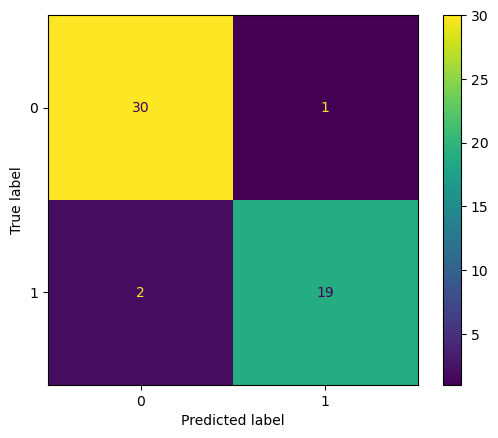

In [37]:
cm = confusion_matrix(test_y,predictions)
disp = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [38]:
cm

array([[30,  1],
       [ 2, 19]])

In [39]:
tpr(cm), tnr(cm)

(0.9, 0.97)

In [40]:
print(f'For decision tree predictions for {stock} in year 2 \
true positive rate, or sesnsitivity/recall, is the proportion of "Green" labels\
 correctly identified and is {tpr(cm)}\
 while true negative rate, or specificity is the proportion of "Red" labels \
 correctly identified and is {tnr(cm)}\
')

For decision tree predictions for SPY in year 2 true positive rate, or sesnsitivity/recall, is the proportion of "Green" labels correctly identified and is 0.9 while true negative rate, or specificity is the proportion of "Red" labels  correctly identified and is 0.97


In [41]:
predictions

array(['Green', 'Red', 'Green', 'Red', 'Green', 'Green', 'Red', 'Red',
       'Green', 'Green', 'Red', 'Green', 'Green', 'Green', 'Green', 'Red',
       'Red', 'Green', 'Red', 'Red', 'Green', 'Green', 'Green', 'Red',
       'Green', 'Green', 'Green', 'Red', 'Green', 'Red', 'Green', 'Green',
       'Red', 'Green', 'Green', 'Red', 'Red', 'Green', 'Red', 'Green',
       'Green', 'Green', 'Green', 'Green', 'Red', 'Green', 'Red', 'Red',
       'Green', 'Red', 'Green', 'Green'], dtype=object)

In [42]:
trade_labels(stock_data,2021,np.where(predictions == 'Green',1,0))

164.84

In [43]:
buy_and_hold(stock_data,2021)

127.54

In [44]:
print(f'For {stock}, b&h yields {buy_and_hold(stock_data,2021)} \
while trading based on decision tree labels yields \
{trade_labels(stock_data,2021,np.where(predictions == "Green",1,0))}')

For SPY, b&h yields 127.54 while trading based on decision tree labels yields 164.84


###### Random Forest

Idea: generate list of dictionaries that contain all possible combinations of parameters that can then be iterated over to get accuracies.

In [45]:
test_results = []
for d in range(1,6):
    for n in range(1,11):
        rf = RandomForestClassifier(criterion = 'entropy', 
                                    n_estimators=n,
                                    max_depth=d,random_state=1)
        rf.fit(train_X,train_y)
        test_results.append((d,n,accuracy_score(test_y,rf.predict(test_X))))
        # rf.score(train_X,train_y)
        

In [46]:
results_df = pd.DataFrame(test_results, columns = ['d','n','accuracy'])
results_df['error'] = 1- results_df['accuracy']

In [47]:
results_df

,d,n,accuracy,error
0,1,1,0.692308,0.307692
1,1,2,0.942308,0.057692
2,1,3,0.750000,0.250000
3,1,4,0.942308,0.057692
4,1,5,0.942308,0.057692
5,1,6,0.942308,0.057692
6,1,7,0.942308,0.057692
7,1,8,0.942308,0.057692
8,1,9,0.942308,0.057692
9,1,10,0.942308,0.057692


[Text(0.5, 1.0, 'SPY RF Error')]

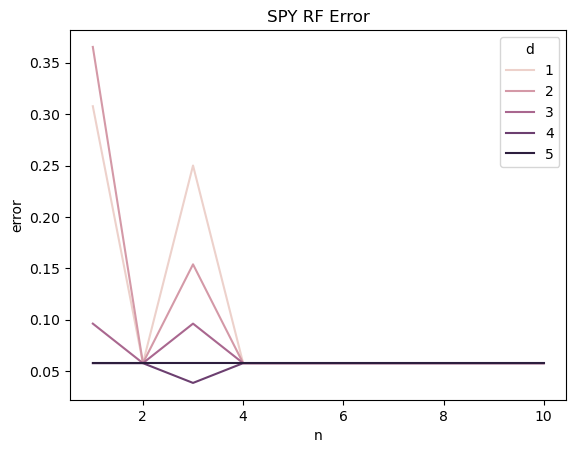

In [48]:
sns.lineplot(results_df, x = 'n', 
             y = 'error', hue='d').set(title = f'{stock.upper()} RF Error')

In [49]:
results_df[results_df.accuracy == 
results_df.loc[results_df['accuracy'].idxmax(),'accuracy']]

,d,n,accuracy,error
32,4,3,0.961538,0.038462


With depth of 4 and n_trees of 3 there is 96.15% accuracy.

In [50]:
rf = RandomForestClassifier(n_estimators=3, max_depth=4,criterion = 'entropy',
                            random_state=1)

In [51]:
rf.fit(train_X,train_y)
preds = rf.predict(test_X)
cm = confusion_matrix(test_y,preds)
print(f'tpr: {tpr(cm)}, tnr: {tnr(cm)}')

tpr: 0.95, tnr: 0.97


In [52]:
cm

array([[30,  1],
       [ 1, 20]])

In [53]:
trade_labels(stock_data,2021,np.where(preds == "Green",1,0))

163.44

In [54]:
buy_and_hold(stock_data,2021)

127.54

###### Adaboost

In [80]:
test_results = []
gnb = GaussianNB()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
estimators = [gnb,lr,dt]
for l in [.5,1]:
    for e in estimators:
        for n in range(1,16):
            ab = AdaBoostClassifier(estimator = e,learning_rate=l,
                                    n_estimators=n, random_state=1)
            
            ab.fit(train_X,train_y)
            test_results.append((l,
                str(type(e)).split('.')[-1][:-2],
                n,accuracy_score(test_y,ab.predict(test_X))))
test_results = pd.DataFrame(test_results,columns=['Lambda',"Estimator",'N_Estimators','Accuracy'])

In [83]:
test_results['Error'] = 1- test_results['Accuracy']

In [84]:
test_results[test_results.Estimator=='LogisticRegression']

,Lambda,Estimator,N_Estimators,Accuracy,Error
15,0.5,LogisticRegression,1,0.596154,0.403846
16,0.5,LogisticRegression,2,0.596154,0.403846
17,0.5,LogisticRegression,3,0.596154,0.403846
18,0.5,LogisticRegression,4,0.596154,0.403846
19,0.5,LogisticRegression,5,0.596154,0.403846
20,0.5,LogisticRegression,6,0.596154,0.403846
21,0.5,LogisticRegression,7,0.596154,0.403846
22,0.5,LogisticRegression,8,0.596154,0.403846
23,0.5,LogisticRegression,9,0.596154,0.403846
24,0.5,LogisticRegression,10,0.596154,0.403846


In [85]:
lambda_pt_5 = test_results[test_results.Lambda==.5].loc[
test_results[test_results.Lambda==.5].groupby('Estimator')[
'Accuracy'].agg('idxmax').values,:
]
lambda_pt_5

,Lambda,Estimator,N_Estimators,Accuracy,Error
30,0.5,DecisionTreeClassifier,1,0.942308,0.057692
4,0.5,GaussianNB,5,0.961538,0.038462
15,0.5,LogisticRegression,1,0.596154,0.403846


In [86]:
test_results[test_results.Lambda==1].loc[
test_results[test_results.Lambda==1].groupby('Estimator')[
'Accuracy'].agg('idxmax').values,:
]

,Lambda,Estimator,N_Estimators,Accuracy,Error
75,1.0,DecisionTreeClassifier,1,0.942308,0.057692
50,1.0,GaussianNB,6,0.961538,0.038462
60,1.0,LogisticRegression,1,0.596154,0.403846


In [87]:
lambda_pt_5

,Lambda,Estimator,N_Estimators,Accuracy,Error
30,0.5,DecisionTreeClassifier,1,0.942308,0.057692
4,0.5,GaussianNB,5,0.961538,0.038462
15,0.5,LogisticRegression,1,0.596154,0.403846


In the table above we wee that best estimator is The DecisionTreeClassifier.

/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


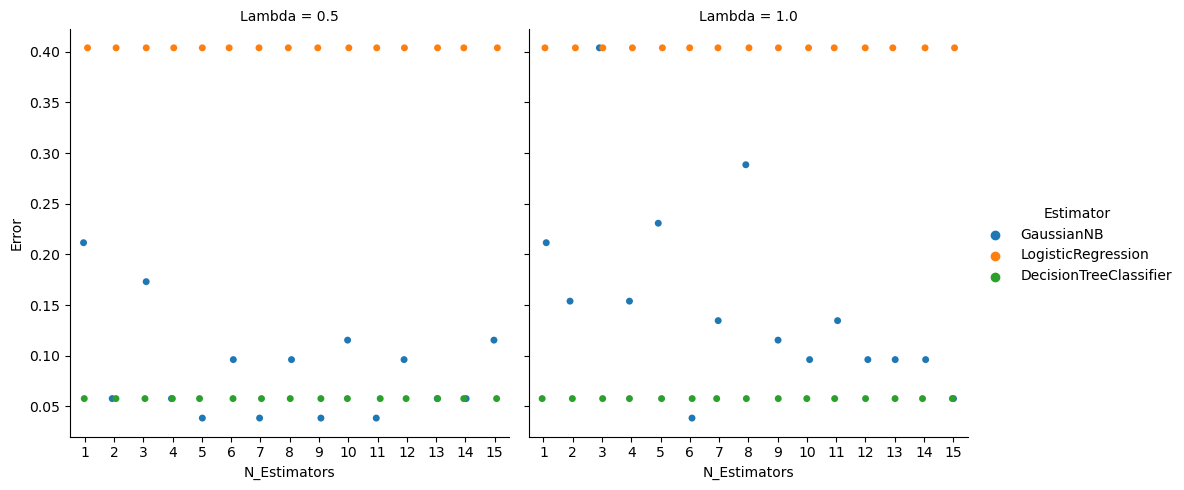

In [61]:
sns.catplot(data=test_results, col = "Lambda",x='N_Estimators',y='Error',
hue = 'Estimator')

for lambda = .5, the best estimator is GaussianNB with n_estimators = 5

In [62]:
ab = AdaBoostClassifier(estimator=GaussianNB(),n_estimators = 5,
                          learning_rate=.5)
ab.fit(train_X,train_y)
preds = ab.predict(test_X)
preds = np.where(preds=="Green",1,0)

In [63]:
trade_labels(stock_data,2021,preds)

165.06

In [64]:
buy_and_hold(stock_data,2021)

127.54

#### Tips

In [65]:
tips = pd.read_csv('./Data/tips.csv')
head_tail(tips)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [66]:
tips['tip_pct'] = tips['tip']/tips['total_bill']

In [67]:
tips.groupby('time')['tip_pct'].agg('mean')

time
Dinner    0.159518
Lunch     0.164128
Name: tip_pct, dtype: float64

In [68]:
tips.groupby('day')['tip_pct'].agg('mean')

day
Fri     0.169913
Sat     0.153152
Sun     0.166897
Thur    0.161276
Name: tip_pct, dtype: float64

In [69]:
tips.groupby(['day','time'])['tip_pct'].agg('mean')

day   time  
Fri   Dinner    0.158916
      Lunch     0.188765
Sat   Dinner    0.153152
Sun   Dinner    0.166897
Thur  Dinner    0.159744
      Lunch     0.161301
Name: tip_pct, dtype: float64

Tips are highest at lunch on Friday.

In [70]:
tips[['total_bill','tip_pct']].corr()

,total_bill,tip_pct
total_bill,1.000000,-0.338624
tip_pct,-0.338624,1.000000


<Axes: xlabel='size', ylabel='tip_pct'>

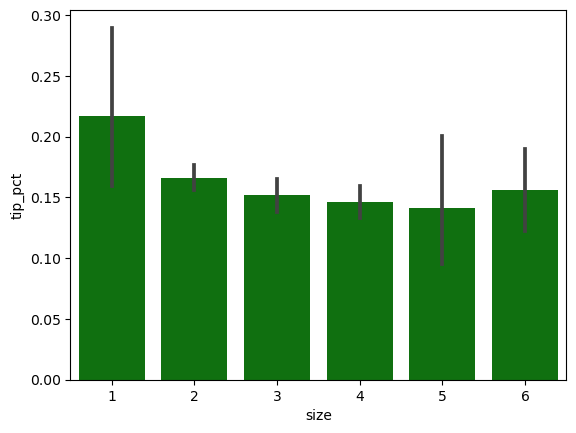

In [71]:
sns.barplot(data=tips,x='size',y='tip_pct',color='g')

In [88]:
np.mean(np.where(tips.smoker=='Yes',1,0))

0.38114754098360654

<Axes: xlabel='size', ylabel='tip_pct'>

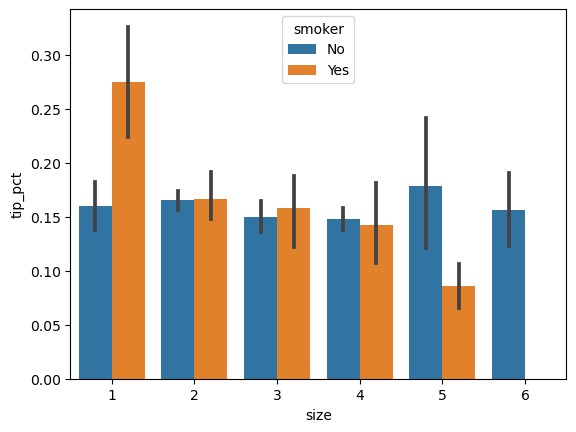

In [72]:
sns.barplot(data=tips,x='size',y='tip_pct',hue='smoker')

In [73]:
tips['inx'] = tips.index

/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


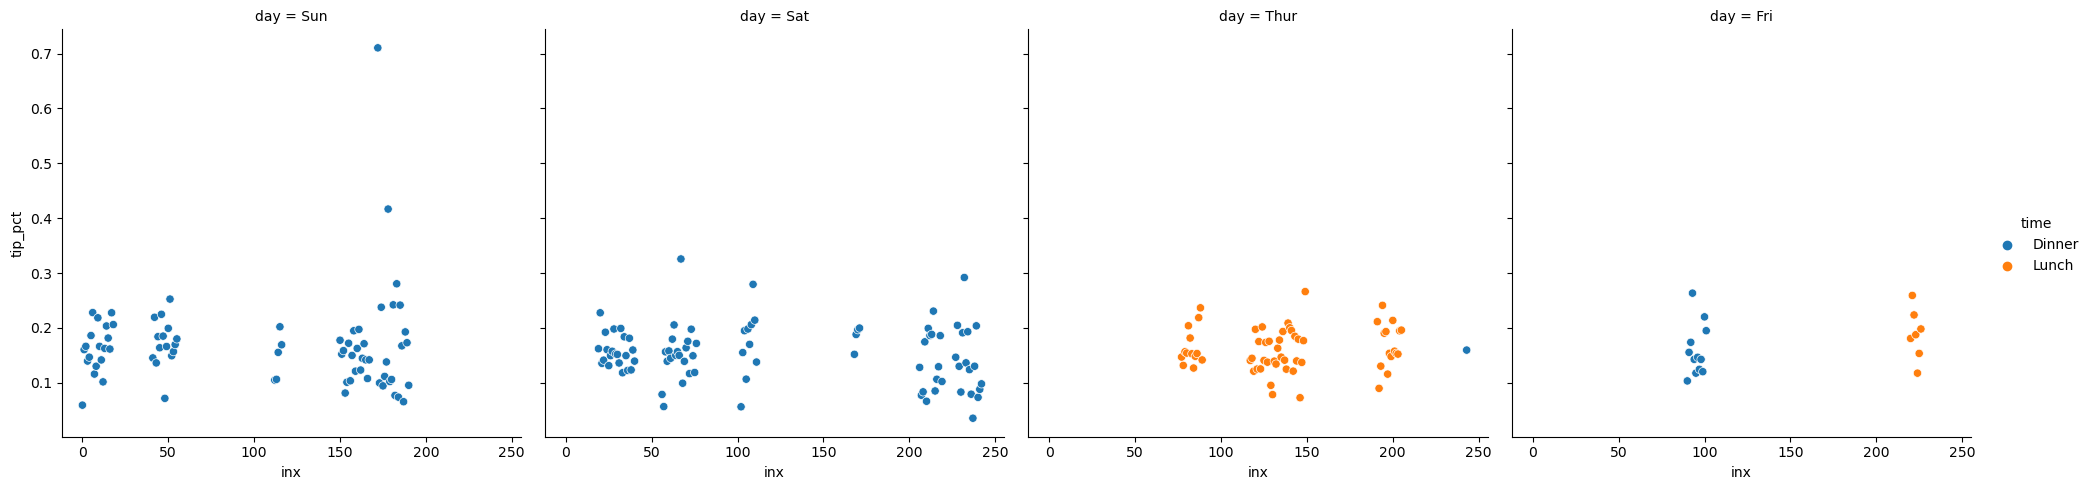

In [74]:
sns.relplot(data=tips,x='inx',y='tip_pct',col = 'day',hue='time')

I don't see a distinctive relationship between the order in which the entries occur in the dataset and the tip_pct.

In [75]:
tips[tips.smoker == 'No'][tips.columns[0:-1]].select_dtypes(
    include='number').corr()['tip_pct']

total_bill   -0.199772
tip           0.349519
size         -0.121354
tip_pct       1.000000
Name: tip_pct, dtype: float64

In [76]:
tips[tips.smoker == 'Yes'][tips.columns[0:-1]].select_dtypes(
    include='number').corr()['tip_pct']

total_bill   -0.457351
tip           0.377667
size         -0.191993
tip_pct       1.000000
Name: tip_pct, dtype: float64

There is a more negative correlation between total bill and tip pct for smokers.

### Scrapyard

In [77]:
def expand_dict(param_dict, new_param_tuple):
    name = new_param_tuple[0],
    value = new_param_tuple[1]
    if param_dict:
        param_dict[name] = value
    else:
        p

In [78]:
def param_expansion(param_grid, param_product):
    if param_grid.keys() == None:
        return param_product
    next_param = param_grid.keys()[0]
    
    param_product
    if len(param_grid.keys())==1:
        p

In [79]:
class grid_evaluation():
    model = object
    def __init__(self, model, params, train_X, train_y):
        self.model = model
        self.params = params
        self.param_combinations = 
    def train_search(self, model = self.model, params=self.params):
        for param in p:
            if p 
        

SyntaxError: invalid syntax (417427532.py, line 6)

In [ ]:
rf = RandomForestClassifier(criterion='entropy')
fgs = GridSearchCV(estimator=rf,
    param_grid = {'n_estimators':[i for i in range(1,11)],
                  'max_depth':[i for i in range(1,6)]},return_train_score=True)
fgs.fit(train_X, y = train_y)
fgs.cv_results_

In [ ]:
def grid_search(model, params):
    """take an n-tuple of parameters in a dictionary format and generate a 
    dataframe with metric results for each combination"""
    
    

In [ ]:
param_combinations = []
param_dict = {'n_trees':[i for i in range(0,11)],
              'max_depth':[i for i in range(0,6)]}
first_dict = dict([(k,v) for k,v in param_dict.items()][0])
# param_combinations.append(param_dict.pop([(k,v) for k,v in param_dict.items()][0]))

for param in param_dict.items():
    for val in param[1]:
        c
k = next(iter(param_dict.keys()))
# param_combinations.append({'c':1})
# param_combinations.append(dict(first_dict))
# (k,param_dict.pop(k))
# param_combinations.append(dict((k, param_dict.pop(k))))
dict(('a',1))